In [1]:
import sys
sys.path.append("../") 

from src.utils.driver import set_seed
from src.utils.model import MLP, MLP_HS
from src.utils.dataset import modular_addition_dataset, ToyDataset, split_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

seed = 57
set_seed(57)
device = 'cuda'

In [2]:
vocab_size = 31
embd_dim = 16
input_token = 2
data_size = 1000
n_exp = 1
dataset = modular_addition_dataset(p=31, num=data_size, seed=seed, device=device)
dataset = split_dataset(dataset, train_ratio=0.8, seed=seed)

batch_size = 32
train_dataset = ToyDataset(dataset['train_data_id'], dataset['train_label'])
test_dataset = ToyDataset(dataset['test_data_id'], dataset['test_label'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
patience = 100
min_delta = 1e-4
counter = 0

num_epochs = 600

In [4]:
def train_gif(model, path_prefix):
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)
    lamb_reg = 0.01

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_inputs, batch_targets in train_dataloader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.type(torch.LongTensor).to(device)
            optimizer.zero_grad()
            outputs = model.forward(batch_inputs)

            criterion = nn.CrossEntropyLoss()#weight=class_weights)
            if 'harmonic' in path_prefix: # Harmonic Model
                loss = (-1)*(outputs[torch.arange(outputs.size(0)), batch_targets.squeeze()].mean())
            else:
                loss = criterion(outputs, batch_targets.squeeze())
            
            if hasattr(model.embedding, 'weight'):
                total_loss = loss + lamb_reg * torch.mean(torch.sqrt(torch.mean(model.embedding.weight**2, dim=0)))
            else:
                total_loss = loss + lamb_reg * torch.mean(torch.sqrt(torch.mean(model.embedding.data**2, dim=0)))
            
            total_loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == batch_targets).sum().item()
            train_total += batch_targets.size(0)

        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"../results/mnist_vis/{path_prefix}_modadd_{epoch+1}.pt")

### H_MLP

In [5]:
weight_tied = True
hidden_size = 100
shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
model = MLP_HS(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, weight_tied=weight_tied, seed=seed, n=n_exp, init_scale=1).to(device)
train_gif(model, path_prefix="harmonic")

100%|██████████| 600/600 [01:11<00:00,  8.34it/s]


### Standard MLP

In [6]:
unembd = True
weight_tied = True
hidden_size = 100
shp = [input_token * embd_dim, hidden_size, embd_dim, vocab_size]
model = MLP(shp=shp, vocab_size=vocab_size, embd_dim=embd_dim, input_token=input_token, unembd=unembd, weight_tied=weight_tied, seed=seed, init_scale=1).to(device)
train_gif(model, path_prefix="standard")

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:40<00:00, 14.88it/s]


In [5]:
import imageio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import torch
from matplotlib.colors import LogNorm

weight_images = []
plt.rcParams.update({'font.size': 16})
prev_standard_pca = None
prev_harmonic_pca = None

for i in range(10, 601, 10):
    weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
    weight_harmonic = torch.load(f"../results/mnist_vis/harmonic_modadd_{i}.pt")

    mnist_standard = torch.load(f"../results/mnist_vis/standard_mnist_{int(i*1.5)}.pt")
    weights_mnist_standard = np.abs(mnist_standard['fc1.weight'].detach().cpu().numpy())[3].reshape(28, 28)
#    weights_mnist_standard = np.where(weights_mnist_standard < 0.01, 1, 0)
    
    mnist_harmonic = torch.load(f"../results/mnist_vis/harmonic_mnist_{int(i*1.5)}.pt")
    weights_mnist_harmonic = np.abs(mnist_harmonic['fc1.weight'].detach().cpu().numpy())[3].reshape(28,28)
#    weights_mnist_harmonic = np.where(weights_mnist_harmonic < 0.01, 1, 0)

    plt.subplots(2, 2, figsize=(9, 6))

    plt.subplot(2, 2, 1)
    plt.title(f"Standard: Addition")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')


    pca = PCA(n_components=2)
    standard_pca = pca.fit_transform(weight_standard['embedding'].cpu().detach().numpy())

    if i > 10 and np.dot(standard_pca[:,0], prev_standard_pca[:,0]) < 0:
        standard_pca *= -1
    prev_standard_pca = standard_pca

    plt.scatter(standard_pca[:, 0], standard_pca[:, 1], label='Standard', s=120)

    ev_text = f"EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.0f}%"
#    plt.text(0.9, 0.1, ev_text, fontsize=16, transform=plt.gca().transAxes, ha='center', va='center')

    plt.subplot(2, 2, 2)
    plt.title(f"Harmonic: Addition")
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('square')


    pca = PCA(n_components=2)
    harmonic_pca = pca.fit_transform(weight_harmonic['embedding'].cpu().detach().numpy())

    if i > 10 and np.dot(harmonic_pca[:,0], prev_harmonic_pca[:,0]) < 0:
        harmonic_pca *= -1
    prev_harmonic_pca = harmonic_pca
    plt.scatter(harmonic_pca[:, 0], harmonic_pca[:, 1], label='Harmonic', s=120)
    
    ev_text = f"EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.0f}%"
#    plt.text(0.9, 0.1, ev_text, fontsize=16, transform=plt.gca().transAxes, ha='center', va='center')


    plt.subplot(2, 2, 3)
    plt.title("Standard: MNIST")

    plt.imshow(weights_mnist_standard)#, norm=LogNorm(vmin=0.005, vmax=0.5))
    plt.axis('off')
#    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title(f"Harmonic: MNIST")
    
    plt.imshow(weights_mnist_harmonic)#, norm=LogNorm(vmin=0.005, vmax=0.5))
    plt.axis('off')
#    plt.colorbar()

    plt.tight_layout()

    temp_plot_path = f"../results/mnist_vis/modadd_{i}.png"
    plt.savefig(temp_plot_path)
    plt.close()
                
    # Read the image and append to list
    weight_images.append(imageio.imread(temp_plot_path))
    print(i)

imageio.mimsave('../figures/weights_evolution.gif', weight_images, duration=0.1, loop=0)

/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
/tmp/ipyke

10


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

20
30


/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
/tmp/ipyke

40
50


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

60
70
80


/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
/tmp/ipyke

90
100


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

110
120


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

130


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

140
150


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

160
170


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

180
190


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

200
210


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

220
230


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

240
250


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

260
270


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

280
290


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

300
310


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

320
330


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

340


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

350
360


/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_standard = torch.load(f"../results/mnist_vis/standard_modadd_{i}.pt")
/tmp/ipyke

370
380


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

390
400


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

410


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

420
430


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

440
450


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

460
470


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

480


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

490
500


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

510
520


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

530
540


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

550
560


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

570
580


/tmp/ipykernel_776975/2596075022.py:90: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  weight_images.append(imageio.imread(temp_plot_path))
/tmp/ipykernel_776975/2596075022.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

590
600


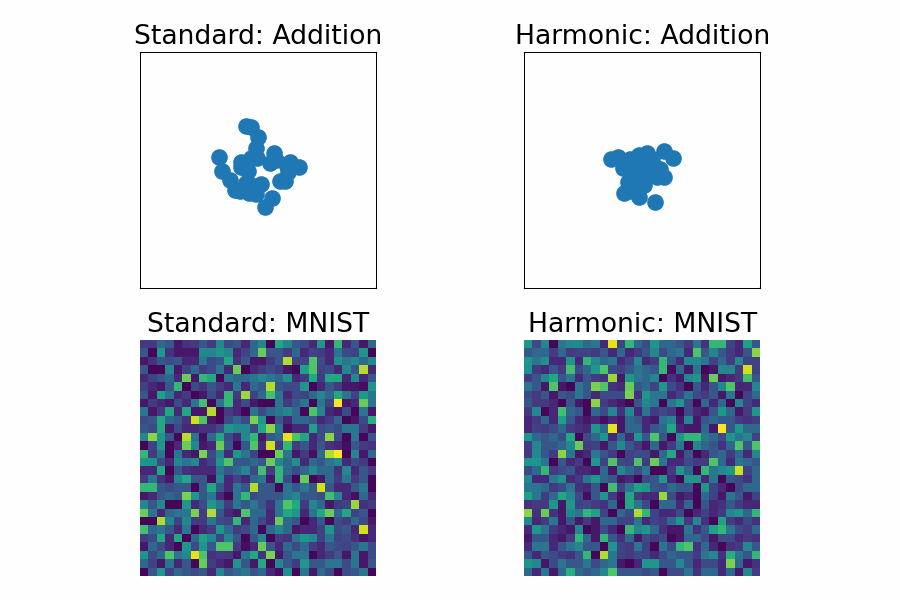

In [6]:
from IPython.display import Image

Image(filename="../figures/weights_evolution.gif")